# Check GPU status

Make surre to use : GPU runtime mode (Runtime->Change Runtime type -> python3 + GPU
)



##Mount Goolge Drive

In [ ]:
# link to google drive

from google.colab import drive
#drive.mount('/content/gdrive/')
drive.mount("/content/gdrive/", force_remount=True)

Mounted at /content/gdrive/


### Ejecutar Codigo en Google Drive

In [ ]:
%cd "/content/gdrive/My Drive/Colab Notebooks/Deep_Prior_Low_Rank-master"

/content/gdrive/My Drive/Colab Notebooks/Deep_Prior_Low_Rank-master


In [ ]:
%ls
import numpy as np
import tensorflow as tf
import scipy.io
import matplotlib as mpl
import matplotlib.pyplot as plt

BGU_9.mat           HJasper1ShotCASSI.mat  RunColab_unmixing_2.ipynb
end4_Abundance.fig  LegoCars.mat           RunColab_unmixing.ipynb
end4.mat            MAIN.py                Script.ipynb
end4_Materials.fig  __pycache__/
H1Shot.mat          RunColab.ipynb


# Data Set
shows the dataset details

(1, 100, 100, 1, 4)
(1, 100, 100, 198)


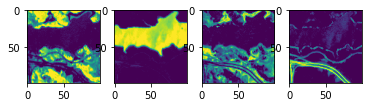

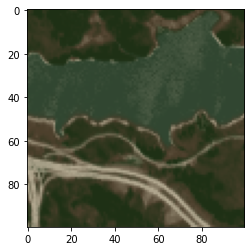

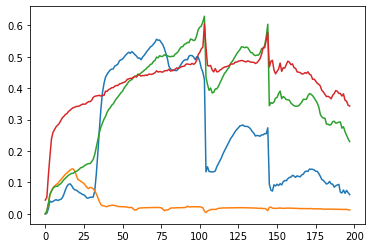

In [ ]:
M = scipy.io.loadmat('end4.mat')['M']
A = scipy.io.loadmat('end4.mat')['A']
A = tf.expand_dims(tf.expand_dims(tf.reshape(tf.transpose(A,[1,0]),[100,100,4]),0),3)
M = tf.expand_dims(tf.expand_dims(tf.expand_dims(M,0),0),0)

print(A.shape)

Hy = tf.reduce_sum(tf.multiply(M,A),axis=4)

print(Hy.shape)

plt.subplot(1,4,1),plt.imshow(A[0,:,:,0,0].numpy())
plt.subplot(1,4,2),plt.imshow(A[0,:,:,0,1].numpy())
plt.subplot(1,4,3),plt.imshow(A[0,:,:,0,2].numpy())
plt.subplot(1,4,4),plt.imshow(A[0,:,:,0,3].numpy())
plt.show()
bad = [int(180),int(100),int(30)]


Hy = Hy.numpy()
most = np.squeeze(Hy)[:,:,[25,16,8]]*2
plt.imshow(most),plt.show()

Ab = np.squeeze(A.numpy(),axis=3)


Mb = tf.reshape(tf.transpose(M,[0,4,3,2,1]),[1,2,2,198]).numpy()
Mb = Mb

plt.plot(Mb[0,0,0,:])
plt.plot(Mb[0,0,1,:])
plt.plot(Mb[0,1,0,:])
plt.plot(Mb[0,1,1,:])
plt.show()

def LMM(x):
  Ab = x[0]
  Mb = x[1]

  Mb = tf.reshape(Mb,[1,1,1,4,198])
  Ab = tf.expand_dims(Ab,-1)
  Hy = tf.reduce_sum(tf.multiply(Mb,Ab),axis=3)

  return Hy


# Network Details

## Endmember network:

This network learn a matrix $E \in \mathbb{R}^{r \times L}$, since  x-> Layer  -> Ex = h



*   r << L, stand for the rank or Endmembers
*   L is the number of expctral band



In [ ]:
from tensorflow.keras.layers import Layer
from tensorflow.keras.constraints import MinMaxNorm,NonNeg
import tensorflow as tf
from MAIN import psnr

#-------------------------------------------- CASSI LAYER-----------------------------------------
class Endmemebers_Layer(Layer):
    def __init__(self, L=16, rank=1, **kwargs):
        self.L = L
        self.rank = rank
        super(Endmemebers_Layer, self).__init__(**kwargs)

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'L': self.L,
            'rank': self.rank})
        return config

    def build(self, input_shape):

            Endmemb = np.random.uniform(0, 1, (1, 1, 1, self.rank, self.L))
            Endmemb = tf.constant_initializer(Endmemb)

            #self.Endmemb = self.add_weight(name='Endmemb', shape=(1, 1, 1, self.rank, self.L), initializer=Endmemb,
            #                               constraint=MinMaxNorm(min_value=0.0, max_value=1.0, rate=1.0, axis=1), trainable=True)

            self.Endmemb = self.add_weight(name='Endmemb', shape=(1, 1, 1, self.rank, self.L), initializer=Endmemb,
                                           constraint=NonNeg(), trainable=True)

    def call(self, inputs, **kwargs):
        #Hy = Rank_operator(inputs,self.Endmemb)
        Ab = tf.expand_dims(inputs,-1)
        Hy = tf.reduce_sum(tf.multiply(self.Endmemb,Ab),axis=3)
        return Hy


## Network part for Abundance Map network:
This we biuld a block of layer to obtain $A \in \mathbb{R}^{M\times N \times r}$, since x-> layers -> layers(x)=A


*   M,N are the dimension of the image



In [ ]:
def Add_weights(x,weights):
    Aux = weights*x[0] + (1-weights)*x[1]
    return Aux


In [ ]:
from keras import backend as K
from IPython.display import clear_output
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

def Abund_net(inputs,rank,name=''):
    conv1 = Conv2D(16, 3, activation='relu', padding='same')(inputs)
    conv2 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv3 = Conv2D(32, 3, activation='relu', padding='same')(conv2)
    conv4 = Conv2D(16, 3, activation='relu', padding='same')(conv3)
    final = Conv2D(rank, 1, activation='softmax', padding='same', name='Abund_final'+str(name))(conv4)

    return final

def Abundance_network(pretrained_weights=None, input_size=(512,512, 31),batch_size = 1, rank = 1):
    inputs = Input(input_size)
    final = Abund_net(inputs,rank)
    hy = Endmemebers_Layer(L=input_size[2], rank=rank)(final)
    conv1 = Conv2D(input_size[2], 3, activation='relu', padding='same')(hy)
    conv1 = Conv2D(input_size[2], 3, activation='relu', padding='same')(conv1)

    Non_linear = Lambda(lambda x: Add_weights(x,0.8)) ([hy,conv1])



    model = Model(inputs, [hy,final])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

In [ ]:
def Abundance_loss():
  def lossimage(y_true, y_pred):
      # batch x W x H X r
    val = tf.reduce_sum(tf.square(y_true - tf.reduce_sum(y_pred,axis=3)))
    return val
  return lossimage

# Reconstruction process **Experiment 1:**

---



## $\mathbf{H=I}$

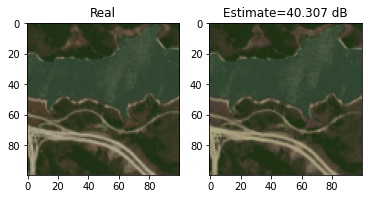

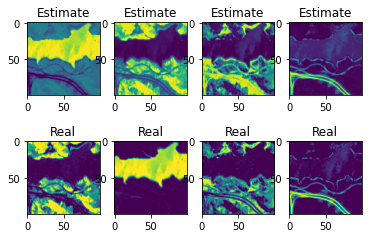

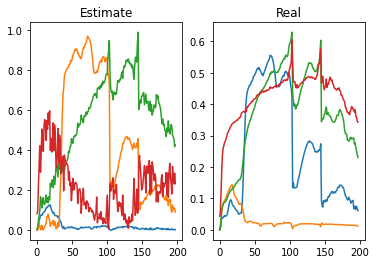

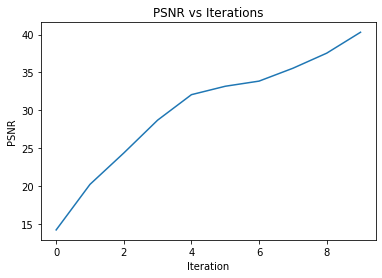

([<matplotlib.lines.Line2D at 0x7f2598672e48>],
 Text(0.5, 1.0, 'PSNR vs Iterations'),
 Text(0.5, 17.200000000000003, 'Iteration'),
 Text(17.200000000000003, 0.5, 'PSNR'),
 None)

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-3,
  decay_steps=10000,
  decay_rate=0.95)
optimizad = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

Abun = Abundance_network(input_size=(100, 100, 198), batch_size=1, rank=4)
Abun.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()], loss_weights=[1,1] )
Internal_iter = 500
psnr_deep = []
for i in range(10):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    Abun.fit(Hy, [Hy, np.ones((1,100,100))], epochs=Internal_iter, batch_size=1, verbose=0)
    temporal = Abun.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([Abun.layers[0].input], [Abun.get_layer('Abund_final').output])
    Image_recon = K.function([Abun.layers[0].input], [Abun.layers[-1].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB'), plt.show()

    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),plt.ylabel('PSNR'),plt.show()



(<matplotlib.axes._subplots.AxesSubplot at 0x7fd89c5c4eb8>,
 Text(0.5, 1.0, 'Estimate=37.065 dB'))

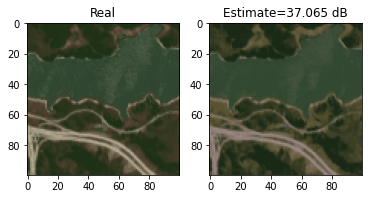

In [ ]:
Image_recon = K.function([Abun.layers[0].input], [Abun.layers[-1].output])
Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
pp = Img_recon[:,:,[25,16,8]]*2


plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB')

# Reconstruction process **Experiment 2:**

---



## $\mathbf{H}$ CASSI System

Prepared Data

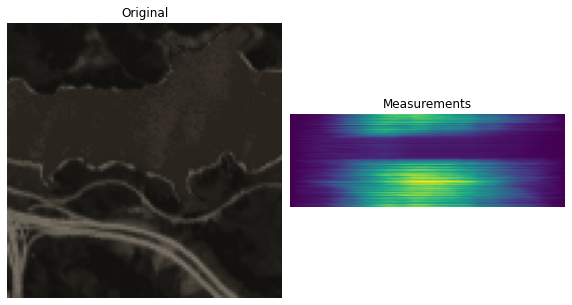

In [ ]:
#Para JASPER dataset
from scipy.sparse import csr_matrix, find
from MAIN import *
# load H
Mat= scipy.io.loadmat('HJasper1ShotCASSI.mat')
H = Mat['H']
[row,col,val] = find(H)
ind = np.asarray([row,col])
ind = np.transpose(ind,(1,0))

H_s = tf.SparseTensor(indices = ind, values = val, dense_shape=[H.shape[0], H.shape[1]])

# Load Data
M       = scipy.io.loadmat('end4.mat')['M']
A       = scipy.io.loadmat('end4.mat')['A']
testSI  = np.double(np.dot(M,A))
L       = testSI.shape[0]
Nm      = int(np.sqrt(testSI.shape[1]))

testSI  = np.double(tf.transpose(tf.reshape(testSI,[L,Nm,Nm]),[1,2,0]))
testSI  = testSI/np.max(testSI)
RGB     = testSI[:,:,(9, 6, 4)]
[m,n,l] = testSI.shape

# Measurements
y = Hxfunction(tf.constant(testSI),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

fig, axs = plt.subplots(1,2,figsize=(10,10))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.03)


axs[0].imshow(RGB)
axs[0].axis('off')
axs[0].set_title('Original')


axs[1].imshow(y.reshape((m,n+l-1),order="F")/np.max(y))
axs[1].axis('off')
axs[1].set_title('Measurements')

del H

In [ ]:
#Para JASPER dataset
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (100,100,1), L=198, H=0, fact = 0.5, rank = 4):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank)
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


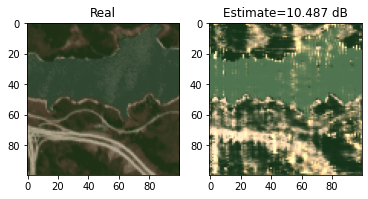

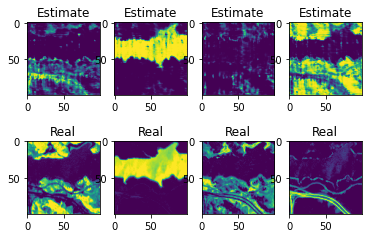

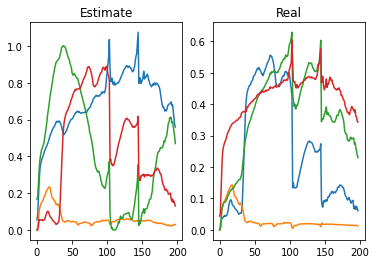

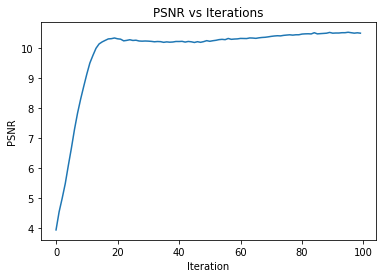

([<matplotlib.lines.Line2D at 0x7f2c6a8be358>],
 Text(0.5, 1.0, 'PSNR vs Iterations'),
 Text(0.5, 17.200000000000003, 'Iteration'),
 Text(17.200000000000003, 0.5, 'PSNR'),
 None)

In [ ]:
#Reconstruction Parameters setup
rho = .2
learning_rate = 1e-4

#Visualization Parameters setup
Freq = 50

#Optimization
model = LMM_Net_reconstruction(input_size = (m,n,l), L=l,H=H_s, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);

model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,1])

Internal_iter = 500
psnr_deep = []
for i in range(100):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    model.fit(np.zeros(shape=(1,m,n,l)), [y, np.ones((1,m,n))], epochs = Internal_iter,batch_size=1,verbose=0)
    temporal = model.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB'), plt.show()

    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),plt.ylabel('PSNR'),plt.show()





## More layers, EA

In [ ]:
#Para JASPER dataset
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (100,100,1), L=198, H=0, fact = 0.5, rank = 4):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank,name='_1')
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    Ab_1 = Abund_net(hy,rank,name='_2')
    hy_1 = Endmemebers_Layer(L=L, rank=rank)(Ab_1)

    Ab_2 = Abund_net(hy_1,rank)
    hy_2 = Endmemebers_Layer(L=L, rank=rank)(Ab_2)

    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy_2)
    final_1 =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy_1)
    final_2 =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy)

    model = Model(inputs, [final,final_1,final_2,Ab,Ab_1,Ab_2])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


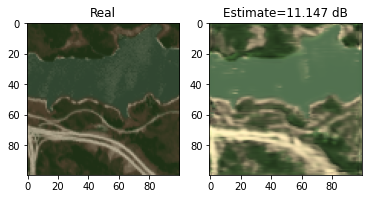

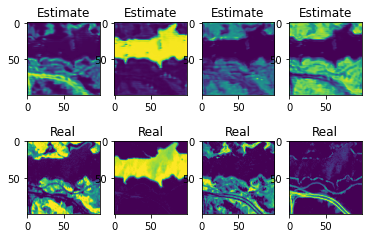

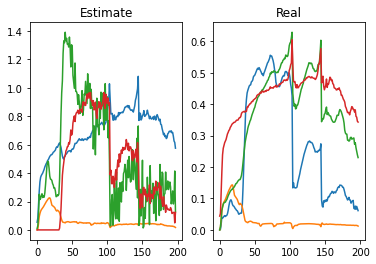

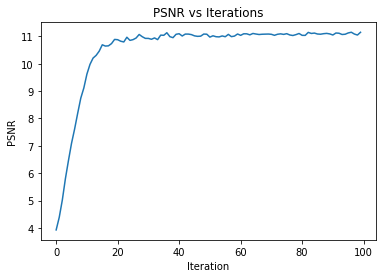

([<matplotlib.lines.Line2D at 0x7fb9aa612940>],
 Text(0.5, 1.0, 'PSNR vs Iterations'),
 Text(0.5, 17.200000000000003, 'Iteration'),
 Text(17.200000000000003, 0.5, 'PSNR'),
 None)

In [ ]:
#Reconstruction Parameters setup
rho = .2
learning_rate = 1e-4

#Visualization Parameters setup
Freq = 50

#Optimization
model = LMM_Net_reconstruction(input_size = (m,n,l), L=l,H=H_s, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);

model.compile(optimizer=optimizad, loss=['mean_squared_error','mean_squared_error','mean_squared_error', Abundance_loss(),Abundance_loss(),Abundance_loss()],loss_weights=[1,1,1,1,1,1])

Internal_iter = 500
psnr_deep = []
for i in range(100):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    model.fit(np.zeros(shape=(1,m,n,l)), [y,y,y, np.ones((1,m,n)),np.ones((1,m,n)),np.ones((1,m,n))], epochs = Internal_iter,batch_size=1,verbose=0)
    temporal = model.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
    Image_recon = K.function([model.layers[0].input], [model.layers[-4].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB'), plt.show()

    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),plt.ylabel('PSNR'),plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb9767110f0>,
 Text(0.5, 1.0, 'Estimate=11.117 dB'))

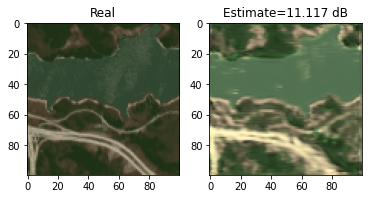

In [ ]:
Image_recon = K.function([model.layers[0].input], [model.layers[-4].output])
Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
ps=psnr(np.squeeze(Hy), Img_recon)
pp = Img_recon[:,:,[25,16,8]]*2


plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(ps)[0:6]+' dB')

# Reconstruction process **Experiment 3:**

---



## $\mathbf{H}$ Burring System

Prepared Data


(1, 100, 100, 198)


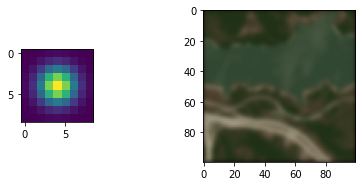

In [ ]:
def gaussian_kernel(kernel_size, sigma, n_channels, dtype):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=dtype)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(tf.cast(sigma, dtype), 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

def blur_operator(high,blur):
    focuse = tf.nn.depthwise_conv2d(high, blur, [1, 1, 1, 1], 'SAME')
    return  focuse


blur = gaussian_kernel(9, 1.5, Hy.shape[3], Hy.dtype)
y = blur_operator(Hy,blur)
pp = np.squeeze(y)
pp = pp[:,:,[25,16,8]]*2
print(y.shape)
plt.subplot(1,4,1),plt.imshow(blur[:,:,0,0])
plt.subplot(1,2,2),plt.imshow(pp)
blur = tf.cast(blur,dtype=tf.float32)

In [ ]:
#Para JASPER dataset
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (100,100,1), L=198, blur=0, fact = 0.5, rank = 4):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank)
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    final =Lambda(lambda x: blur_operator(x,blur=blur)) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

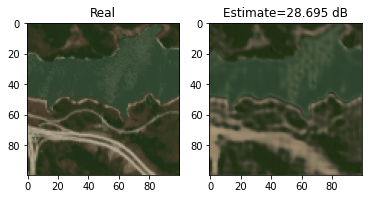

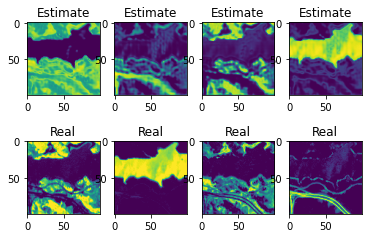

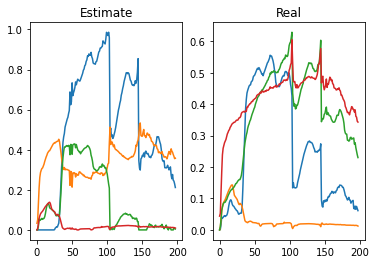

Iteration = 24


In [ ]:
#Reconstruction Parameters setup
rho = .2
learning_rate = 1e-4

#Visualization Parameters setup
Freq = 50

#Optimization
model = LMM_Net_reconstruction(input_size = (m,n,l), L=l,blur=blur, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);

model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,1])

Internal_iter = 500
psnr_deep = []
for i in range(100):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    model.fit(np.zeros(shape=(1,m,n,l)), [y, np.ones((1,m,n))], epochs = Internal_iter,batch_size=1,verbose=0)
    temporal = model.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB'), plt.show()

    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),plt.ylabel('PSNR'),plt.show()

# Reconstruction process **Experiment 4:**

---



## $\mathbf{H=D}$ super resolution


(1, 25, 25, 198)


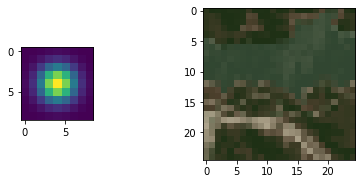

In [ ]:
def Desimation_Super(x,factor,w):
    Aux = tf.image.resize(x,[int(np.round(w/factor)),int(np.round(w/factor))])
    return Aux


y = Desimation_Super(Hy,4,100)
pp = np.squeeze(y)
pp = pp[:,:,[25,16,8]]*2
print(y.shape)
plt.subplot(1,4,1),plt.imshow(blur[:,:,0,0])
plt.subplot(1,2,2),plt.imshow(pp)
blur = tf.cast(blur,dtype=tf.float32)

In [ ]:
#Para JASPER dataset
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (100,100,1), L=198, fact = 0.5, rank = 4):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank)
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    final =Lambda(lambda x: Desimation_Super(x,4,100)) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

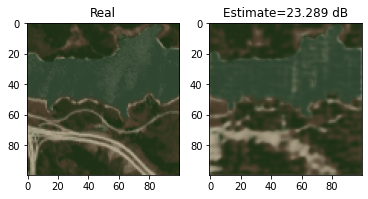

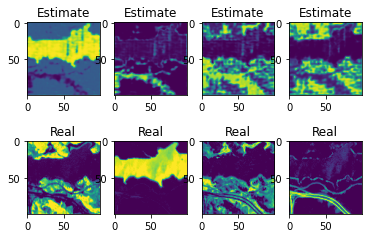

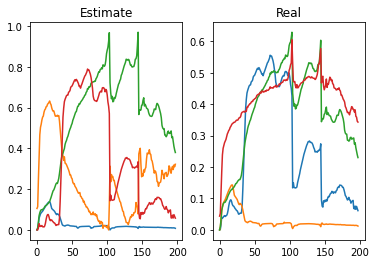

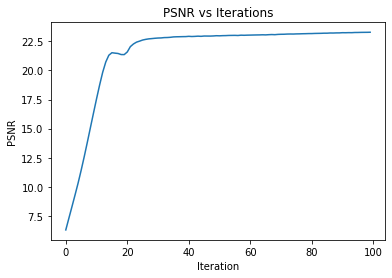

([<matplotlib.lines.Line2D at 0x7f0a0bf38668>],
 Text(0.5, 1.0, 'PSNR vs Iterations'),
 Text(0.5, 17.200000000000003, 'Iteration'),
 Text(17.200000000000003, 0.5, 'PSNR'),
 None)

In [ ]:
#Reconstruction Parameters setup
rho = .2
learning_rate = 1e-4

#Visualization Parameters setup
Freq = 50

#Optimization
model = LMM_Net_reconstruction(input_size = (m,n,l), L=l, fact= rho)
optimizad = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.9, amsgrad=False);

model.compile(optimizer=optimizad, loss=['mean_squared_error', Abundance_loss()],loss_weights=[1,1])

Internal_iter = 500
psnr_deep = []
for i in range(100):
    print('Iteration = ' + str(i))
    clear_output(wait=True)

    model.fit(np.zeros(shape=(1,m,n,l)), [y, np.ones((1,m,n))], epochs = Internal_iter,batch_size=1,verbose=0)
    temporal = model.get_weights()
    # obtain the CA
    Endm = np.squeeze(temporal[-1])
    H_high = K.function([model.layers[0].input], [model.get_layer('Abund_final').output])
    Image_recon = K.function([model.layers[0].input], [model.layers[-2].output])
    Img_recon = np.squeeze(np.asarray(Image_recon(Hy)))
    rest_h = np.squeeze(np.asarray(H_high(Hy)))
    psnr_deep.append(psnr(np.squeeze(Hy), Img_recon))

    pp = Img_recon[:,:,[25,16,8]]*2

    plt.subplot(1,2,1),plt.imshow(most),plt.title('Real')
    plt.subplot(1,2,2),plt.imshow(pp),plt.title('Estimate='+ str(psnr_deep[-1])[0:6]+' dB'), plt.show()

    plt.subplot(2, 4, 1), plt.imshow(rest_h[:, :, 0]), plt.title('Estimate')
    plt.subplot(2, 4, 2), plt.imshow(rest_h[:, :, 1]), plt.title('Estimate')
    plt.subplot(2, 4, 3), plt.imshow(rest_h[:, :, 2]), plt.title('Estimate')
    plt.subplot(2, 4, 4), plt.imshow(rest_h[:, :, 3]), plt.title('Estimate')

    plt.subplot(2, 4, 5), plt.imshow(Ab[0, :, :, 0]), plt.title('Real')
    plt.subplot(2, 4, 6), plt.imshow(Ab[0, :, :, 1]), plt.title('Real')
    plt.subplot(2, 4, 7), plt.imshow(Ab[0, :, :, 2]), plt.title('Real')
    plt.subplot(2, 4, 8), plt.imshow(Ab[0, :, :, 3]), plt.title('Real')
    plt.show()

    plt.subplot(1,2,1), plt.plot(np.transpose(Endm)), plt.title('Estimate')
    plt.subplot(1, 2, 2), plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:]), plt.title('Real')
    plt.show()

    plt.subplot()

plt.plot(psnr_deep),plt.title('PSNR vs Iterations'),plt.xlabel('Iteration'),plt.ylabel('PSNR'),plt.show()

# other experiment H

In [ ]:
from scipy.sparse import csr_matrix, find
from MAIN import *
# load H
Mat= scipy.io.loadmat('H1Shot.mat')
H = Mat['H']
[row,col,val] = find(H)
ind = np.asarray([row,col])
ind = np.transpose(ind,(1,0))

print(H.shape)

H_s = tf.SparseTensor(indices = ind, values = val, dense_shape=[H.shape[0], H.shape[1]])

# Load Data
Mat= scipy.io.loadmat('LegoCars.mat')
testSI=np.double(Mat['hyperimg'])
testSI=testSI/np.max(testSI)
RGB = testSI[:,:,(8, 4, 1)]
[m,n,l]=testSI.shape

# Measurements
y = Hxfunction(tf.constant(testSI),largo=m,ancho=n,profun=l,H=H_s)
y = np.double(y.numpy())

fig, axs = plt.subplots(1,2,figsize=(10,10))
fig.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.03)


axs[0].imshow(RGB)
axs[0].axis('off')
axs[0].set_title('Original')


axs[1].imshow(y.reshape((m,n+l-1),order="F")/np.max(y))
axs[1].axis('off')
axs[1].set_title('Measurements')

del H

IndentationError: ignored

In [ ]:
def LMM_Net_reconstruction(pretrained_weights=None, input_size = (256,256,1), L=10, H=0, fact = 0.5, rank = 20):
    inputs = Input(input_size)
    inicial = XoLayer(largo=input_size[0], ancho=input_size[1], profun=L, fact=fact)(inputs)
    drop1 = Dropout(0.2)(inicial)

    Ab = Abund_net(drop1,rank)
    hy = Endmemebers_Layer(L=L, rank=rank)(Ab)

    final =Lambda(lambda x: Hxfunction(x,largo=input_size[0],ancho=input_size[1],profun=L,H=H)) (hy)

    model = Model(inputs, [final,Ab])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

# Network part for Endmemebrs

In [ ]:
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output
from keras import backend as K

from os import listdir
from os.path import isfile, join

import numpy as np
import scipy.io
from scipy.io import loadmat
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

# important part load the psf layer

def Spect3D(L_int,input):

    x = tf.keras.backend.expand_dims(input,axis=-1)
    x1 = Conv3D(L_int, (1, 1, 3), padding='same', strides=1, activation='relu')(x)
    x2 = Conv3D(1, (1, 1, 3), padding='same', strides=1,  activation='relu')(x1)
    x3 = tf.keras.backend.squeeze(x2,axis=-1)
    return x3

def End_net(inputs):
    block1 = Spect3D(16, input=inputs)
    av1 = AveragePooling2D(pool_size=(2,2))(block1)
    block2 = Spect3D(16, input=av1)
    av2 = AveragePooling2D(pool_size=(5,5))(block2)
    block3 = Spect3D(32, input=av2)
    av3 = AveragePooling2D(pool_size=(5,5))(block3)
    final = Spect3D(32, input=av3)
    final1 = Conv2D(198, 1, padding='same', strides=1,  activation='sigmoid', name = 'End_final')(final)
    return final1



def Endmember_network(pretrained_weights=None, input_size=(100, 100, 198)):

    inputs = Input(input_size)
    final = End_net(inputs)

    model = Model(inputs, final)

    if (pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-3,
  decay_steps=10000,
  decay_rate=0.95)
optimizad = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

EndNet = Endmember_network(input_size=(100, 100, 198))
EndNet.compile(optimizer=optimizad, loss='mean_squared_error',metrics=['mse','mae'])

Internal_iter = 10
psnr_deep = []

print(Hy.shape)
print(Mb.shape)


for i in range(150):
    print('Iteration = ' +str(i))
    clear_output(wait=True)

    EndNet.fit(Hy, Mb , epochs=Internal_iter, batch_size=1,verbose=0)
    H_high = K.function([EndNet.layers[0].input], [EndNet.get_layer('End_final').output])
    rest_h = np.squeeze(np.asarray(H_high(Hy)))

    print(rest_h.shape)
    plt.subplot(1,2,1),plt.plot(rest_h[0,0,:])
    plt.plot(rest_h[0,1,:])
    plt.plot(rest_h[1,0,:])
    plt.plot(rest_h[1,1,:])

    plt.subplot(1,2,2),plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:])
    plt.show()



plt.plot(psnr_deep),plt.show()



KeyboardInterrupt: ignored

#all together

In [ ]:
def LMM_network(pretrained_weights=None, input_size=(512,512, 31),batch_size = 1, rank = 1):
    inputs = Input(input_size)
    Abundance = Abund_net(inputs,rank)
    Endmembers = End_net(inputs)

    Hy = Lambda(lambda x:LMM(x),name='final')((Abundance,Endmembers))

    #Hy = tf.keras.backend.expand_dims(Hy,axis=-1)
    #Hy = Conv3D(32, (1, 1, 3), padding='same', strides=1, activation='relu')(Hy)
    #Hy = Conv3D(1, (1, 1, 3), padding='same', strides=1,  activation='relu')(Hy)
    #Hy = tf.keras.backend.squeeze(Hy,axis=-1)

    model = Model(inputs, [Hy, Abundance,Endmembers])
    if (pretrained_weights):
        model.load_weights(pretrained_weights)
    return model

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
  initial_learning_rate=1e-3,
  decay_steps=10000,
  decay_rate=0.95)
optimizad = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

my_net = LMM_network(input_size=(100,100,198),batch_size = 1, rank = 4)
my_net.compile(optimizer=optimizad, loss='categorical_crossentropy',metrics=['accuracy'])

Internal_iter = 10
psnr_deep = []
for i in range(150):
    print('Iteration = ' +str(i))
    clear_output(wait=True)

    my_net.fit(Hy,[Hy,Ab,Mb],epochs=Internal_iter, batch_size=1,verbose=0)
    Abb = K.function([my_net.layers[0].input],  [my_net.get_layer('Abund_final').output])
    Ebb = K.function([my_net.layers[0].input],  [my_net.get_layer('End_final').output])
    Hybb = K.function([my_net.layers[0].input],  [my_net.get_layer('final').output])


    rest_h = np.squeeze(np.asarray(Abb(Hy)))
    rest_e = np.squeeze(np.asarray(Ebb(Hy)))
    rest_hy = np.squeeze(np.asarray(Hybb(Hy)))


    plt.subplot(2,4,1),plt.imshow(rest_h[:,:,0])
    plt.subplot(2,4,2),plt.imshow(rest_h[:,:,1])
    plt.subplot(2,4,3),plt.imshow(rest_h[:,:,2])
    plt.subplot(2,4,4),plt.imshow(rest_h[:,:,3])

    plt.subplot(2,4,5),plt.imshow(Ab[0,:,:,0])
    plt.subplot(2,4,6),plt.imshow(Ab[0,:,:,1])
    plt.subplot(2,4,7),plt.imshow(Ab[0,:,:,2])
    plt.subplot(2,4,8),plt.imshow(Ab[0,:,:,3])
    plt.show()

    plt.subplot(1,2,1),plt.plot(rest_e[0,0,:])
    plt.plot(rest_e[0,1,:])
    plt.plot(rest_e[1,0,:])
    plt.plot(rest_e[1,1,:])

    plt.subplot(1,2,2),plt.plot(Mb[0,0,0,:])
    plt.plot(Mb[0,0,1,:])
    plt.plot(Mb[0,1,0,:])
    plt.plot(Mb[0,1,1,:])
    plt.show()


    plt.subplot(1,2,1),plt.plot(rest_hy[5,5,:])
    plt.plot(rest_hy[25,25,:])
    plt.plot(rest_hy[50,50,:])
    plt.plot(rest_hy[80,80,:])

    plt.subplot(1,2,2),plt.plot(Hy[0,5,5,:])
    plt.plot(Hy[0,25,25,:])
    plt.plot(Hy[0,50,50,:])
    plt.plot(Hy[0,80,80,:])
    plt.show()



plt.plot(psnr_deep),plt.show()

KeyboardInterrupt: ignored

In [ ]:
my_net.fit(Hy,[Hy,Ab,Mb],epochs=100, batch_size=1,verbose=1)